# Cello 0.0.2

Update : implemented attention mechanism for better prediction and visualization of inference.

The training data was downloaded from [BindingDB](bindingdb.org ) provided by UCSD.

## Data preprocessing



In [ ]:
import torch
import torchtext
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
data_drop = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CPI project/data_drop.csv')
data_drop

,Ligand SMILES,IC50 (nM),BindingDB Target Chain Sequence
0,CC(C)[C@H](NC(C)=O)C(=O)N[C@@H](Cc1ccccc1)[C@@...,85,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...
1,CC(C)C[C@]1(N=CC([C@@H](Cc2ccccc2)C(N)=O)C1=O)...,10,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...
2,CC(C)[C@H](NC(=O)c1ccc2ccccc2n1)C(=O)N[C@@H](C...,10,PQFSLWKRPVVTAYIEGQPVEVLLDTGADDSIVAGIELGNNYSPKI...
3,Cc1cc(NCN2C(=O)c3ccccc3C2=O)c(=O)[nH]c1C,218,PISPIETVPVKLKPGMDGPKVKQWPLTEEKIKALVEICTEMEKEGK...
4,CC(C)[C@H](NC(=O)[C@@H](C[C@H](O)[C@H](Cc1cccc...,11,PQVTLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...
...,...,...,...
4737,Cc1c(Br)cc(NC(=O)CS(O)(=O)=O)cc1Br,62,MAEVGSKSVLFVCLGNICRSPIAEAVFRKLVTDEKVSDNWRIDSAA...
4738,Cc1c(Br)cc(NC(=O)CS(O)(=O)=O)cc1Br,62,MAEVGSKSVLFVCLGNICRSPIAEAVFRKLVTDENVSDNWRIDSAA...
4739,NCCNS(=O)(=O)c1ccc(cc1)-c1ccc(CSc2nc3CCCc3c(=O...,83,MIRLGAPQTLVLLTLLVAAVLRCQGQDVQEAGSCVQDGQRYNDKDV...
4740,COC(=O)C[C@H]1[C@@]2(C)[C@H](C[C@@H]3CC(C(C)=C...,240,MAAQQRDCGGAAQLAGPAAEADPLGRFTCPVCLEVYEKPVQVPCGH...


In [ ]:
# split into train, valid, test dataset and convert to iterable dataset type
from torch.utils.data.dataset import random_split

_train = []
for data_list in data_drop.values:
  _train.append(data_list)

num_train = int(len(_train) * 0.90)
num_test = int(len(_train)*0.05)
_train, _valid, _test = random_split(_train, [num_train, len(_train) - num_train - num_test, num_test])


In [ ]:
!pip install deepchem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 6.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
jax 0.4.20 requires scipy>=1.9, but you have scipy 1.8.1 which is incompatible.
jaxlib 0.4.20+cuda11.cudnn86 requires scipy>=1.9, but you have scipy 1.8.1 which is incompatible.


Tokenize amino acid sequence and SMILES sequence

In [ ]:
from torchtext.vocab import vocab
from torchtext.data.utils import get_tokenizer
from deepchem.feat.smiles_tokenizer import BasicSmilesTokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = iter(_train)
valid_iter = iter(_valid)
test_iter = iter(_test)

tokenize_smiles = BasicSmilesTokenizer()

def yield_tokens(file_iter, type = 0):
     if type == 0:
        for line in file_iter:
            smi_token = list(tokenize_smiles.tokenize(str(line[0])))
            smi_token.append('<eos>')
            smi_token.insert(0, '<sos>')
            yield smi_token
     else:
        for line in file_iter:
            aa_token = list(line[2])
            aa_token.append('<eos>')
            aa_token.insert(0, '<sos>')
            yield aa_token

smiles_voc = build_vocab_from_iterator(yield_tokens(train_iter, 0), specials=["<unk>", "<pad>", "<sos>", "<eos>"])
train_iter = iter(_train)
aa_voc = build_vocab_from_iterator(yield_tokens(train_iter, 1), specials=["<unk>", "<pad>", "<sos>", "<eos>"])
smiles_voc.set_default_index(smiles_voc['<unk>'])
aa_voc.set_default_index(aa_voc['<unk>'])

In [ ]:
print(len(smiles_voc))
print(len(aa_voc))

77
29


Add `<sos>` and `<eos>` token to start / end

In [ ]:
def be(a_list):
    a_list.append('<eos>')
    a_list.insert(0, '<sos>')
    return a_list

smiles_pipeline = lambda x: smiles_voc(be(tokenize_smiles.tokenize(str(x))))
aa_pipeline = lambda x: aa_voc(be(list(x)))

In [ ]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def custom_collate_fn(batch):
    aa_list, smiles_list, aa_len = [], [], []
    for [_smi, _, _aa] in batch:
         processed_smi = torch.tensor(smiles_pipeline(_smi), dtype=torch.int64)
         smiles_list.append(processed_smi)
         processed_aa = torch.tensor(aa_pipeline(_aa), dtype=torch.int64)
         aa_list.append(processed_aa)
         aa_len.append(len(processed_aa))
    smiles_list = pad_sequence(smiles_list, padding_value = 1)
    aa_list = pad_sequence(aa_list, padding_value = 1)

    return aa_list.to(device), smiles_list.to(device), aa_len

In [ ]:
train_iter = iter(_train)
valid_iter = iter(_valid)
test_iter = iter(_test)

train_dataloader = DataLoader(list(train_iter), batch_size=2,
                              shuffle=True, collate_fn=custom_collate_fn)

valid_dataloader = DataLoader(list(valid_iter), batch_size=2,
                              shuffle=True, collate_fn=custom_collate_fn)

test_dataloader = DataLoader(list(test_iter), batch_size=2,
                              shuffle=True, collate_fn=custom_collate_fn)

## Build the model

- based on https://towardsdatascience.com/attn-illustrated-attention-5ec4ad276ee3

![](https://miro.medium.com/max/1400/1*qN2Pj5J4VqAFf7dsA2dHpA.png)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)

        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)

        self.fc = nn.Linear(enc_hid_dim*2, dec_hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, aa, aa_len):

        #aa = [aa len, batch size]
        #aa_len = [batch size]

        embedded = self.dropout(self.embedding(aa))
        #embedded = [aa len, batch size, emb dim]

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths = aa_len, enforce_sorted = False)


        packed_outputs, hidden = self.rnn(packed_embedded)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        #outputs = [aa len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]

        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer

        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        #hidden = [batch size, dec hid dim]

        return outputs, hidden

In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()

        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)

    def forward(self, hidden, encoder_outputs, mask):

        #hidden = [batch size, dec hid dim] from decoder
        #encoder_outputs = [src len, batch size, enc hid dim * 2] from bidirectional encoder

        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]

        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2)))
        #energy = [batch size, src len, dec hid dim] #nn.Linear(dec_hid_dim, 1)

        attention = self.v(energy).squeeze(2)

        #attention = [batch size, src len]

        attention = attention.masked_fill(mask == 0, -1e10)

        return nn.functional.softmax(attention, dim = 1)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention

        self.embedding = nn.Embedding(output_dim, emb_dim)

        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)

        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs, mask):

        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]

        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]

        input = input.unsqueeze(0)
        #input = [1, batch size]

        embedded = self.dropout(self.embedding(input))

        #embedded = [1, batch size, emb dim]

        a = self.attention(hidden, encoder_outputs, mask)

        #a = [batch size, src len]

        a = a.unsqueeze(1)

        #a = [batch size, 1, src len]

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        #encoder_outputs = [batch size, src len, enc hid dim * 2]

        weighted = torch.bmm(a, encoder_outputs)

        #weighted = [batch size, 1, enc hid dim * 2]

        weighted = weighted.permute(1, 0, 2)

        #weighted = [1, batch size, enc hid dim * 2]

        rnn_input = torch.cat((embedded, weighted), dim = 2)

        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]

        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))

        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]

        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)

        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))

        #prediction = [batch size, output dim]

        return prediction, hidden.squeeze(0), a.squeeze(1)

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, aa_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.aa_pad_idx = aa_pad_idx
        self.device = device

    def create_mask(self, aa):
        mask = (aa != self.aa_pad_idx).permute(1, 0)
        return mask

    def forward(self, aa, aa_len, smi, teacher_forcing_ratio = 0.5):

        #aa = [aa len, batch size]
        #src_len = [batch size]
        #smi = [smi len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time

        if smi is None:
            smi = torch.zeros((50, aa.shape[1])).fill_(2).long().to(aa.device)

        batch_size = smi.shape[1]
        smi_len = smi.shape[0]
        smi_vocab_size = self.decoder.output_dim

        #tensor to store decoder outputs
        outputs = torch.zeros(smi_len, batch_size, smi_vocab_size).to(self.device)

        #last hidden state of the encoder is used as the initial hidden state of the decoder
        encoder_outputs, hidden = self.encoder(aa, aa_len)

        #first input to the decoder is the <sos> tokens
        input = smi[0,:]

        mask = self.create_mask(aa)
        #mask = [batch size, aa_len]

        for t in range(1, smi_len):

            #insert input token embedding, previous hidden, all enconder hidden states, and mask
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)

            #place predictions in a tensor holding predictions for each token
            outputs[t] = output

            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio

            #get the highest predicted token from our predictions
            top1 = output.argmax(1)

            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = smi[t] if teacher_force else top1

        return outputs

In [ ]:
INPUT_DIM = len(aa_voc)
OUTPUT_DIM = len(smiles_voc)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
AA_PAD_IDX = aa_voc(['<pad>'])[0]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, AA_PAD_IDX, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(29, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(77, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=77, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 6,598,477 trainable parameters


Then we define our optimizer and criterion.

The `ignore_index` for the criterion needs to be the index of the pad token for the target SMILES, not the source amino acid sequence.

In [ ]:
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
SMI_PAD_IDX = smiles_voc(['<pad>'])[0]
criterion = nn.CrossEntropyLoss(ignore_index = SMI_PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):

    model.train()
    log_interval = 10
    epoch_loss = 0

    for i, batch in enumerate(iterator):

        aa = batch[0]
        smi = batch[1]
        aa_len = batch[2]
        batch_loss = 0

        optimizer.zero_grad()

        output = model(aa, aa_len, smi)

        #smi = [smi len, batch size]
        #output = [smi len, batch size, output dim]

        output_dim = output.shape[-1]

        output = output[1:].view(-1, output_dim)
        smi = smi[1:].view(-1)

        #smi = [(smi len - 1) * batch size]
        #output = [(smi len - 1) * batch size, output dim]

        loss = criterion(output, smi)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()
        batch_loss += loss.item()

        if i % log_interval == 0 and i > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| loss {:8.2f}'.format(epoch+1, i, len(iterator),
                                           batch_loss))

    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            aa = batch[0]
            smi = batch[1]
            aa_len = batch[2]

            output = model(aa, aa_len, smi, 0) #turn off teacher forcing

            #smi = [smi len, batch size]
            #output = [smi len, batch size, output dim]

            output_dim = output.shape[-1]

            output = output[1:].view(-1, output_dim)
            smi = smi[1:].view(-1)

            #smi = [(smi len - 1) * batch size]
            #output = [(smi len - 1) * batch size, output dim]

            loss = criterion(output, smi)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

The penultimate step is to train our model.

In [ ]:
import time
import random
import math

N_EPOCHS = 6
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_dataloader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_dataloader, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'cello-002-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

| epoch   1 |    10/ 2134 batches | loss     2.51
| epoch   1 |    20/ 2134 batches | loss     2.80
| epoch   1 |    30/ 2134 batches | loss     2.45
| epoch   1 |    40/ 2134 batches | loss     2.39
| epoch   1 |    50/ 2134 batches | loss     2.32
| epoch   1 |    60/ 2134 batches | loss     2.54
| epoch   1 |    70/ 2134 batches | loss     2.51
| epoch   1 |    80/ 2134 batches | loss     2.48
| epoch   1 |    90/ 2134 batches | loss     2.35
| epoch   1 |   100/ 2134 batches | loss     2.66
| epoch   1 |   110/ 2134 batches | loss     2.25
| epoch   1 |   120/ 2134 batches | loss     2.80
| epoch   1 |   130/ 2134 batches | loss     2.01
| epoch   1 |   140/ 2134 batches | loss     1.93
| epoch   1 |   150/ 2134 batches | loss     2.26
| epoch   1 |   160/ 2134 batches | loss     2.41
| epoch   1 |   170/ 2134 batches | loss     2.16
| epoch   1 |   180/ 2134 batches | loss     2.02
| epoch   1 |   190/ 2134 batches | loss     1.96
| epoch   1 |   200/ 2134 batches | loss     1.94


OutOfMemoryError: ignored

Finally, we load the parameters from our best validation loss and get our results on the test set.


In [ ]:
import time
import random
import math

model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/CPI project/cello-002-model.pt'))

test_loss = evaluate(model, test_dataloader, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.685 | Test PPL:  14.662 |


## Inference

Now we can use our trained model to generate SMILES code.

**Note:** these translations will be poor compared to examples shown in paper as they use hidden dimension sizes of 1000 and train for 4 days! They have been cherry picked in order to show off what attention should look like on a sufficiently sized model.

Our `generate_inhibitor` will do the following:
- ensure our model is in evaluation mode, which it should always be for inference
- tokenize the source amino acid sequence
- numericalize the tokens
- convert it to a tensor and add a batch dimension
- get the length of the AA sequence and convert to a tensor
- feed the sequence into the encoder
- create the mask for the AA sequence
- create a list to hold the output SMILES, initialized with an `<sos>` token
- create a tensor to hold the attention values
- while we have not hit a maximum length (50 here)
  - get the input tensor, which should be either `<sos>` or the last predicted token
  - feed the input, all encoder outputs, hidden state and mask into the decoder
  - store attention values
  - get the predicted next token
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output SMILES from indexes to tokens
- return the output SMILES (with the `<sos>` token removed) and the attention values over the sequence

In [297]:
def generate_inhibitor(aa_seq, smi_seq):
  tokenized = be(list(aa_seq)) #tokenize sentence
  numericalized = aa_voc.lookup_indices(tokenized) #convert tokens into indexes
  aa_len = torch.tensor(len(numericalized)).unsqueeze(0)
  tensor = torch.LongTensor(numericalized).unsqueeze(1).to(device) #convert to tensor and add batch dimension

  with torch.no_grad():
    encoder_outputs, hidden = model.encoder(tensor, aa_len)

  mask = model.create_mask(tensor)
  smiles_indexes = smiles_voc.lookup_indices(be(tokenize_smiles.tokenize(smi_seq)))
  attentions = torch.zeros(50, 1, len(numericalized)).to(device)
  smiles = []

  for i in range(50):
    smiles_tensor = torch.LongTensor([smiles_indexes[0]]).to(device)

    with torch.no_grad():
      output, hidden, attention = model.decoder(smiles_tensor, hidden, encoder_outputs, mask)

    attentions[i] = attention
    pred_token = output.argmax(1).item()
    smiles.append(pred_token)

    if pred_token == smiles_voc(['<eos>'])[0]:
      break

  smiles = smiles_voc.lookup_tokens(smiles) #we ignore the first token, just like we do in the training loop

  return ''.join(smiles[1:]), attentions[:len(smiles)-1]

Next, we'll make a function that displays the model's attention over the AA sequence for each target token generated.

In [300]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().numpy()

    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=5)

    x_ticks = [''] + ['<sos>'] + [t for t in sentence] + ['<eos>']
    y_ticks = [''] + list(translation)

    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

An example from the training dataset:

- Generated inhibitor seems to have simple carbons repeated
- Attention also shows only the last column(`<eos>`) was used for generating SMILES

In [302]:
candidate = _train[8][2]
candidate_inhibitor = _train[8][0]

print(f'Amino acid sequence: {candidate}')
print(len(candidate))
print(f'Inhibitor: {candidate_inhibitor}')

Amino acid sequence: MLSFQYPDVYRDETSVQDYHGHKICDPYAWLEDPDSEQTKAFVEAQNKITVPFLEQCPIRGLYKERMTELYDYPKYSCHFKKGKRYFYFYNTGLQNQRVLYVQDSLEGEARVFLDPNTLSDDGTVALRGYAFSEDGEYFAYGLSASGSDWVTIKFMKVDGAKELPDVLERVKFTCMAWTHDGKGMFYNSYPQQDGKSDGTETSTNLHQKLCYHVLGTDQSEDVLCAEFPDEPKWMGGAELSDDGRYVLLSIWEGCDPVNRLWYCDLQQGSNGINGILKWVKLIDNFEGEYDYITNEGTVFTFKTNRNSPNYRLINIDFTDPDESKWKVLVPEHEKDVLEWVACVRSNFLVLCYLRNVKNILQLHDLTTGALLKTFPLDVGSVVGYSGRKKDSEIFYQFTSFLSPGVIYHCDLTREELEPRVFREVTVKGIDASDYQTIQVFYPSKDGTKIPMFIVHKKGIKLDGSHPAFLYGYGGFNISITPNYSVSRLIFVRHMGGVLAVANIRGGGEYGETWHKGGILANKQNCFDDFQCAAEYLIKEGYTTSKRLTINGGSNGGLLVAACANQRPDLFGCVIAQVGVMDMLKFHKFTIGHAWTTDYGCSDSKQHFEWLLKYSPLHNVKLPEADDIQYPSMLLLTADHDDRVVPLHSLKFIATLQYIVGRSRKQSNPLLIHVDTKAGHGPGKPTAKVIEEVSDMFAFIARCLNIEWIQ
710
Inhibitor: O=C(C1CC(C1)c1ccccc1)N1C2CCC(CC2)[C@H]1C(=O)N1CCCC1


In [303]:
inhibitor, attention = generate_inhibitor(candidate, candidate_inhibitor)

print(f'Generated inhibitor: {inhibitor}')

Generated inhibitor: CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC


<ipython-input-300-8636fa165f0c>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-300-8636fa165f0c>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


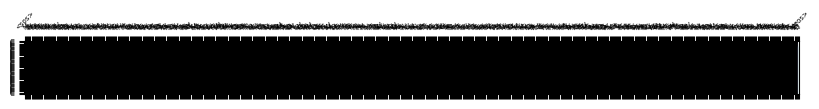

In [304]:
display_attention(candidate, inhibitor, attention)

Another example using a simpler AA sequence

- Shows that most of the information is being extracted from the last two AA seqences


Generated inhibitor: CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC


<ipython-input-300-8636fa165f0c>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-300-8636fa165f0c>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


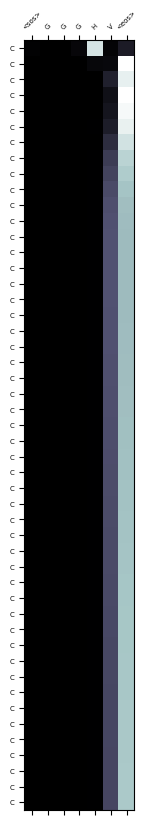

In [360]:
candidate = 'GGGHV'
inhibitor, attention = generate_inhibitor(candidate, candidate_inhibitor)
print(f'Generated inhibitor: {inhibitor}')
display_attention(candidate, inhibitor, attention)

## Further improvements:
- Better architecture : Transformer implementation (Self-, Multi-head attention)
- Pretrained embedding : grouping amino acids with similar properties can help
- Computational chemistry methods : Calculating actual physicochemical properties of proteins can help in prediction
